In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')
sys.path.insert(0, '../firmware')

In [38]:

import numpy
import pandas

from load import load_recordings
from processing import DataProcessor, State

In [3]:
data_path = '../data/fake-1/record/'
files = load_recordings(data_path)
files

Failed to read all data for array. Expected (1040, 6) = 6240 elements, could only read 4368 elements. (file seems not fully written?)
Failed to read all data for array. Expected (1040, 6) = 6240 elements, could only read 1872 elements. (file seems not fully written?)


,data,classname
filename,,
0000-00-00T012458_rowing.npy,gyro_x gyro_y gyro_z ac...,rowing
0000-00-00T012536_rowing.npy,gyro_x gyro_y gyro_z ac...,rowing
0000-00-00T012343_other.npy,gyro_x gyro_y gyro_z ac...,other
0000-00-00T012422_other.npy,gyro_x gyro_y gyro_z ac...,other
0000-00-00T012556_rowing.npy,gyro_x gyro_y gyro_z ac...,rowing
0000-00-00T012403_other.npy,gyro_x gyro_y gyro_z ac...,other
0000-00-00T012246_other.npy,gyro_x gyro_y gyro_z ac...,other
0000-00-00T012615_rowing.npy,gyro_x gyro_y gyro_z ac...,rowing
0000-00-00T012324_other.npy,gyro_x gyro_y gyro_z ac...,other


In [4]:
rec = files.iloc[0].data

In [5]:
import seaborn

[0 0 0 ... 6 6 6]
[ 0  0  0 ... 14 14 14]
[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]
[0 0 0 ... 7 7 7]
[0 0 0 ... 0 0 0]
[0 0 0 ... 5 5 5]
[0 0 0 ... 1 1 1]
[0 0 0 ... 5 5 5]
[0 0 0 ... 2 2 2]
[0 0 0 ... 6 6 6]
[0 0 0 ... 1 1 1]
[0 0 0 ... 3 3 3]
[0 0 0 ... 0 0 0]


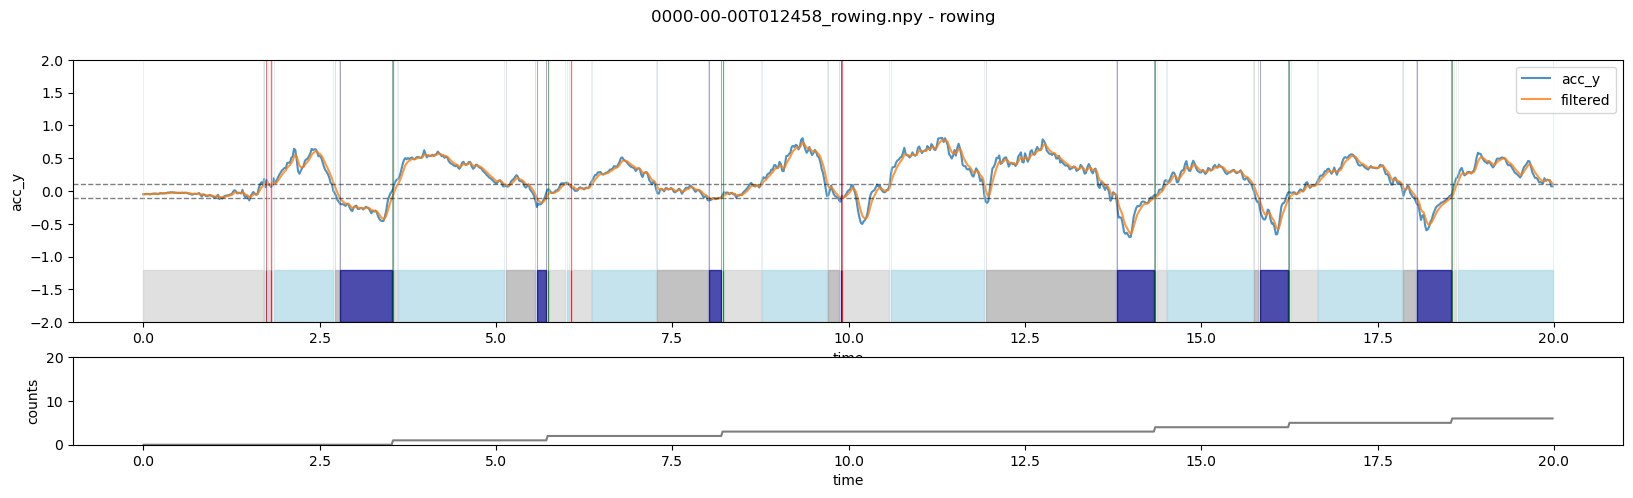

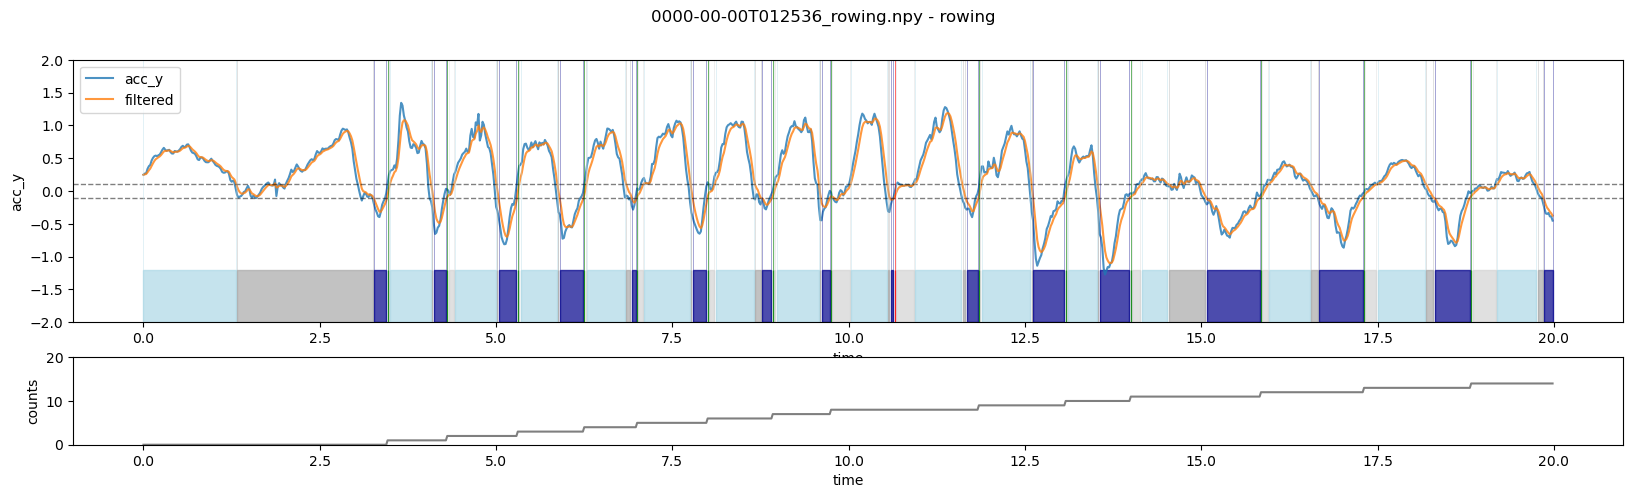

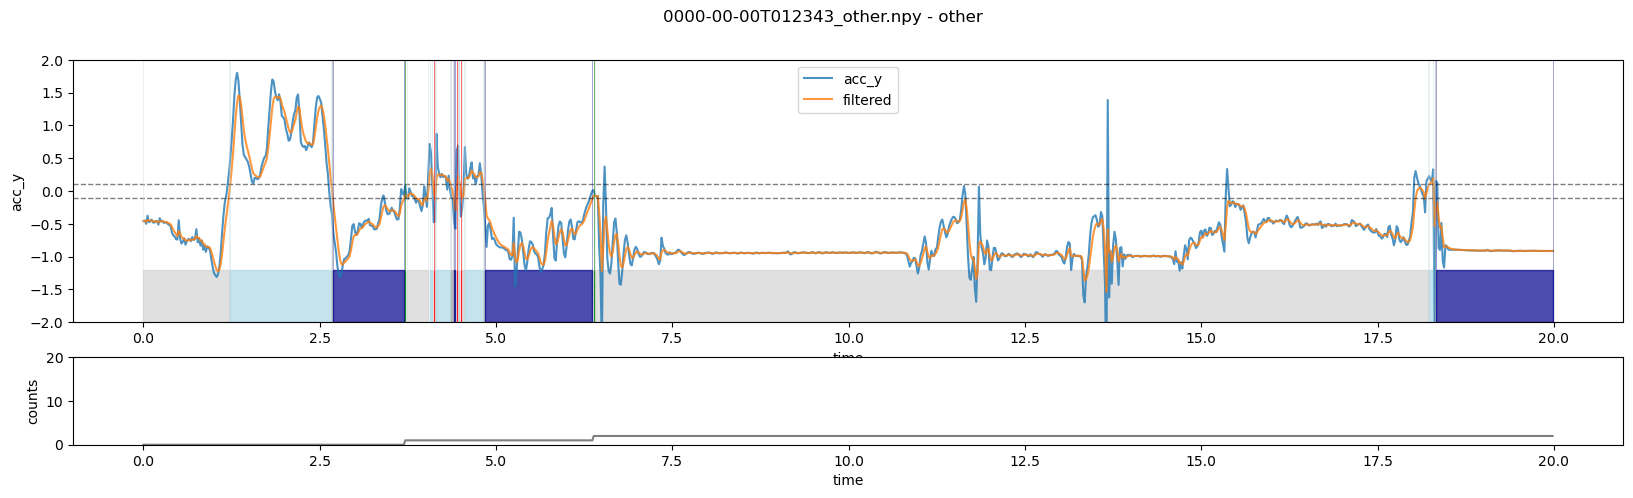

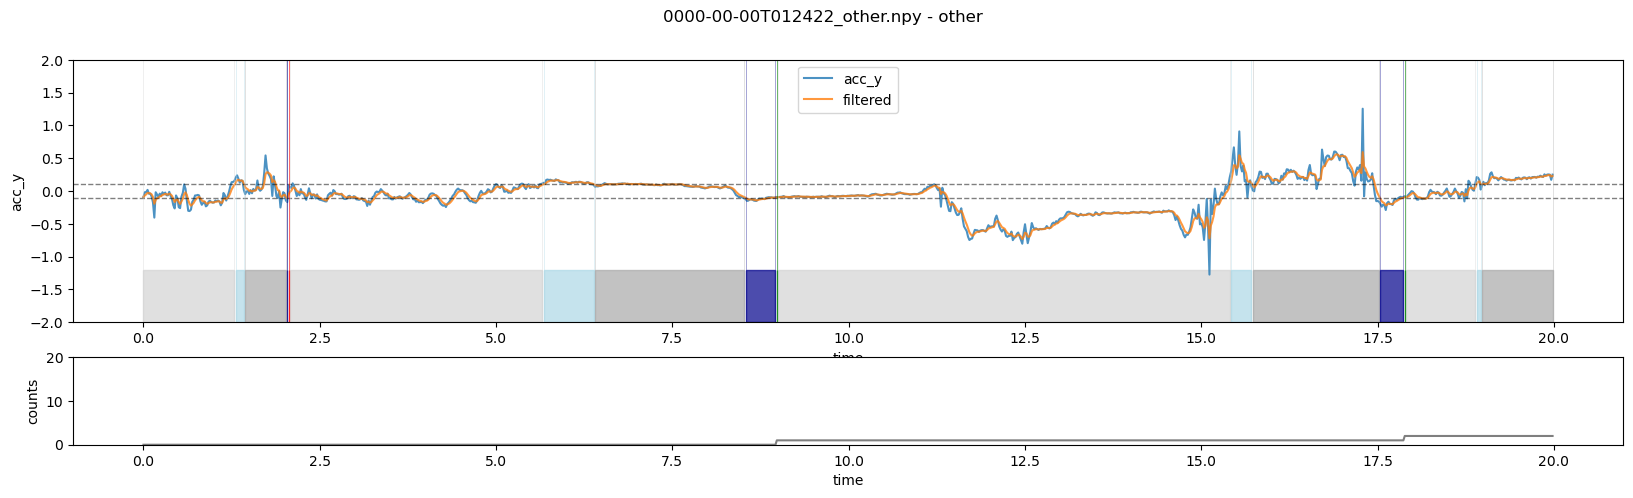

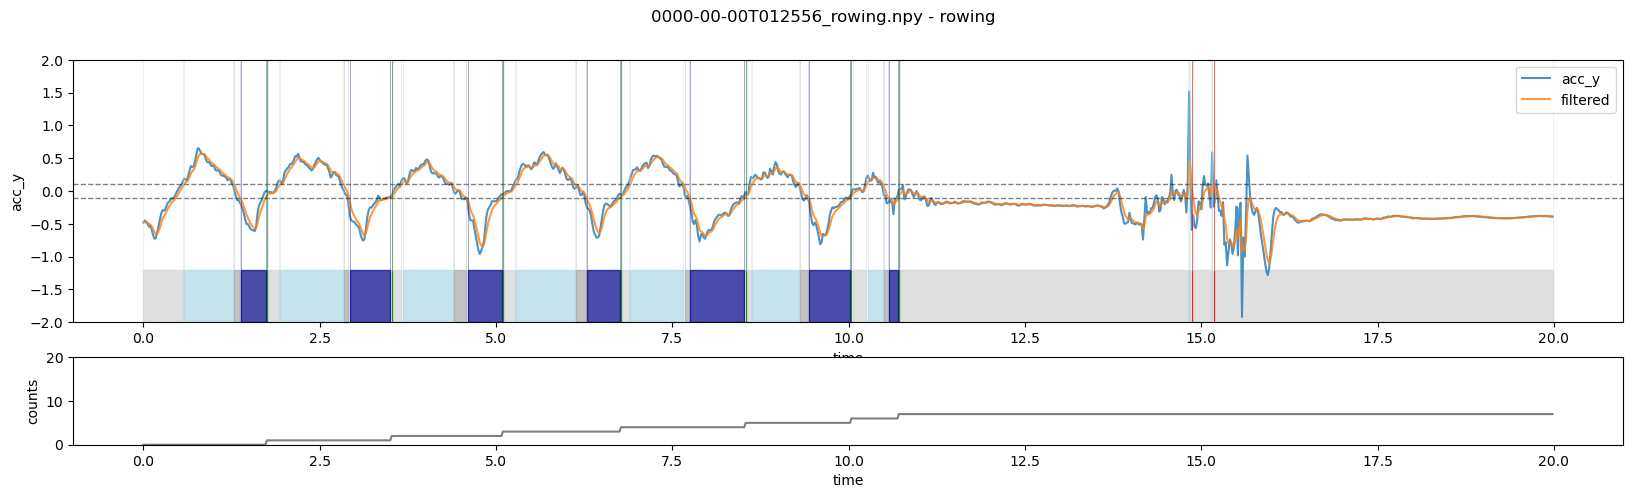

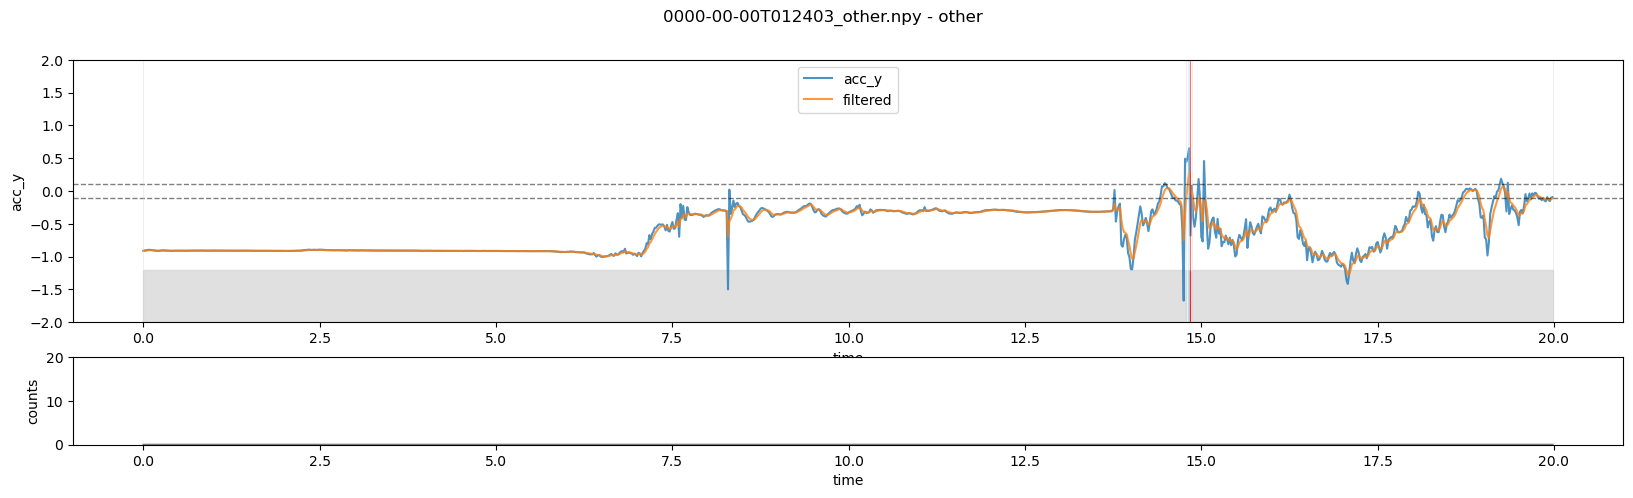

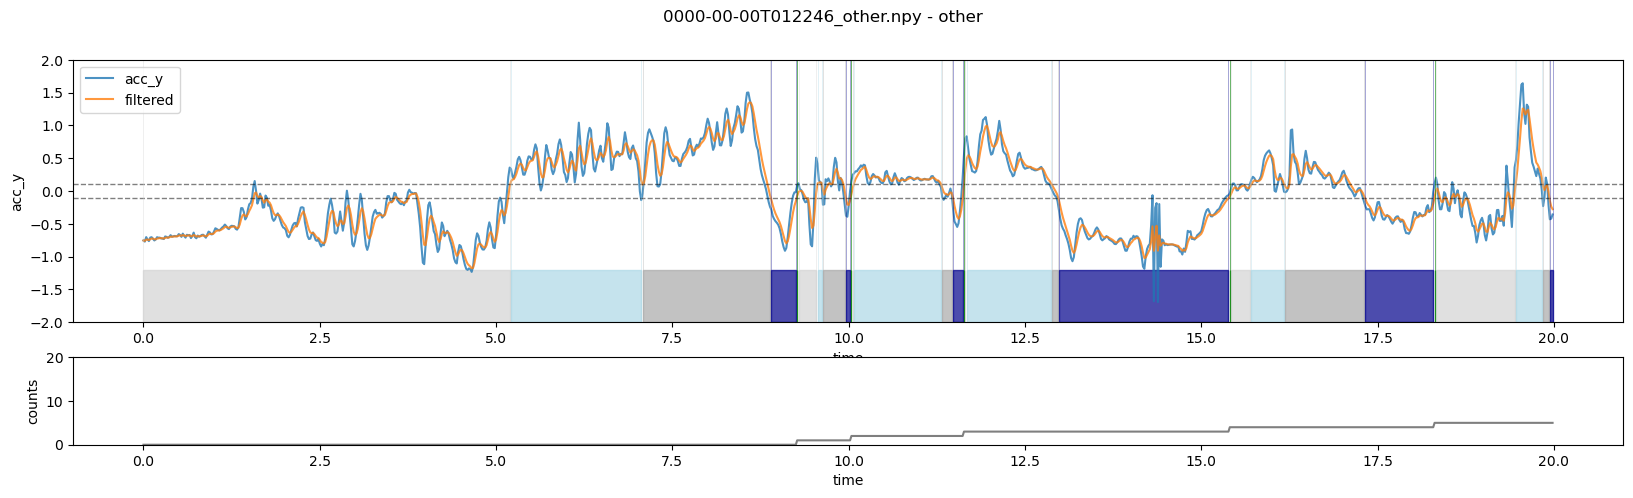

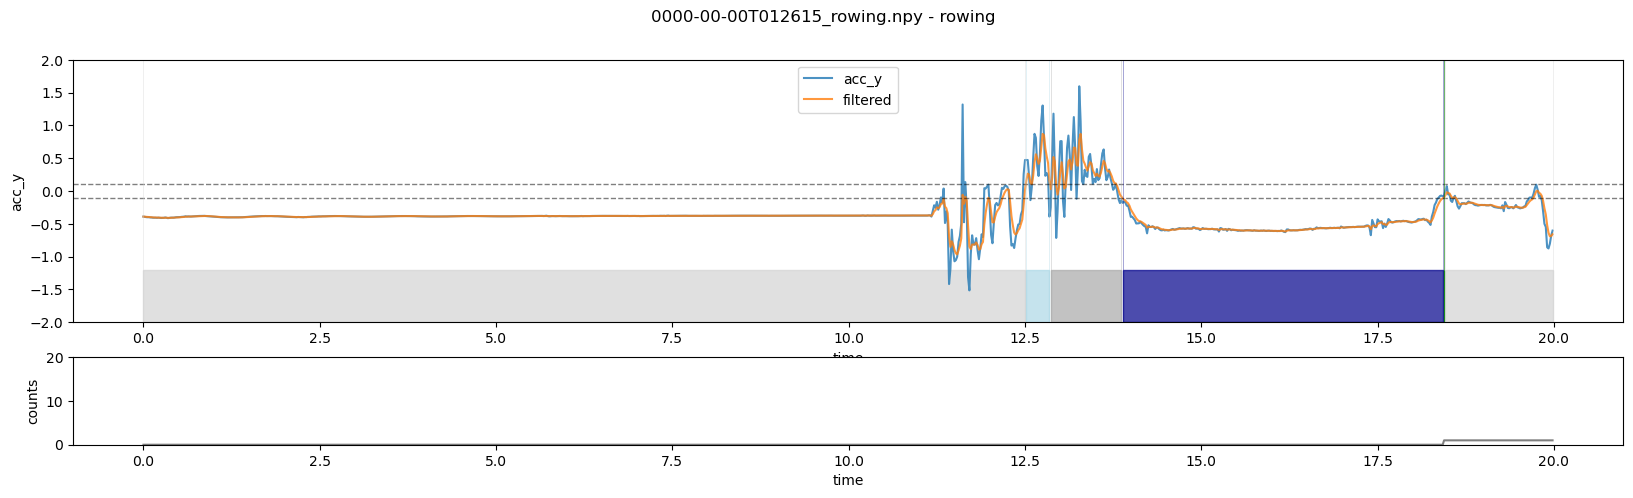

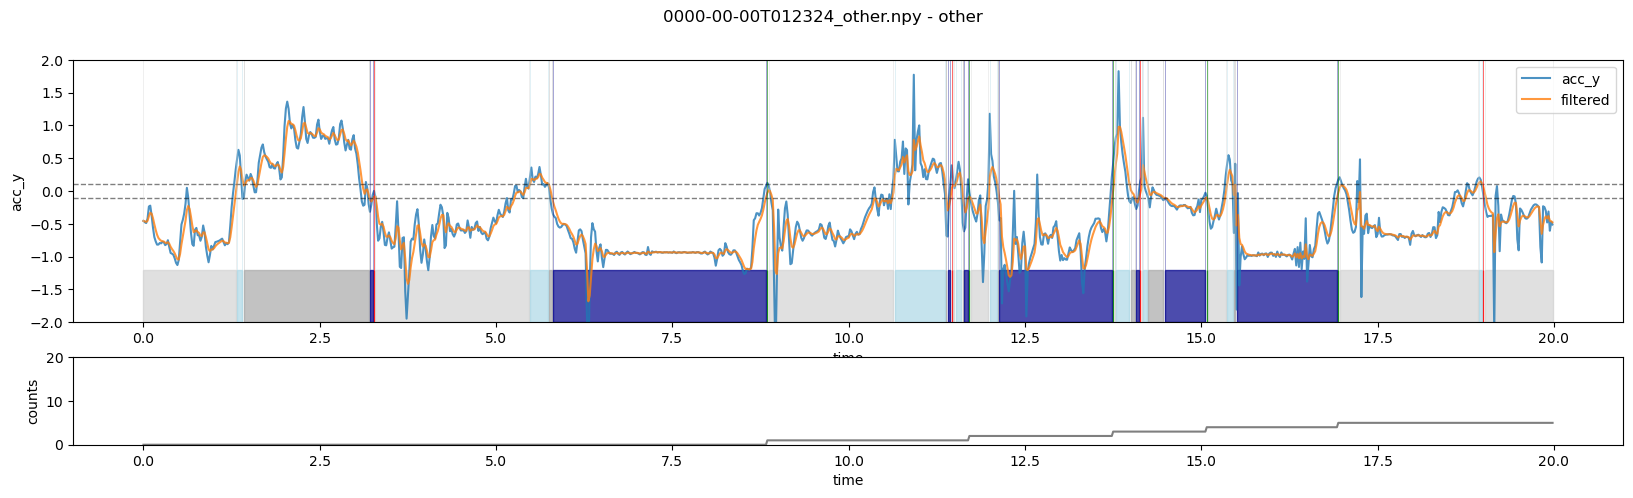

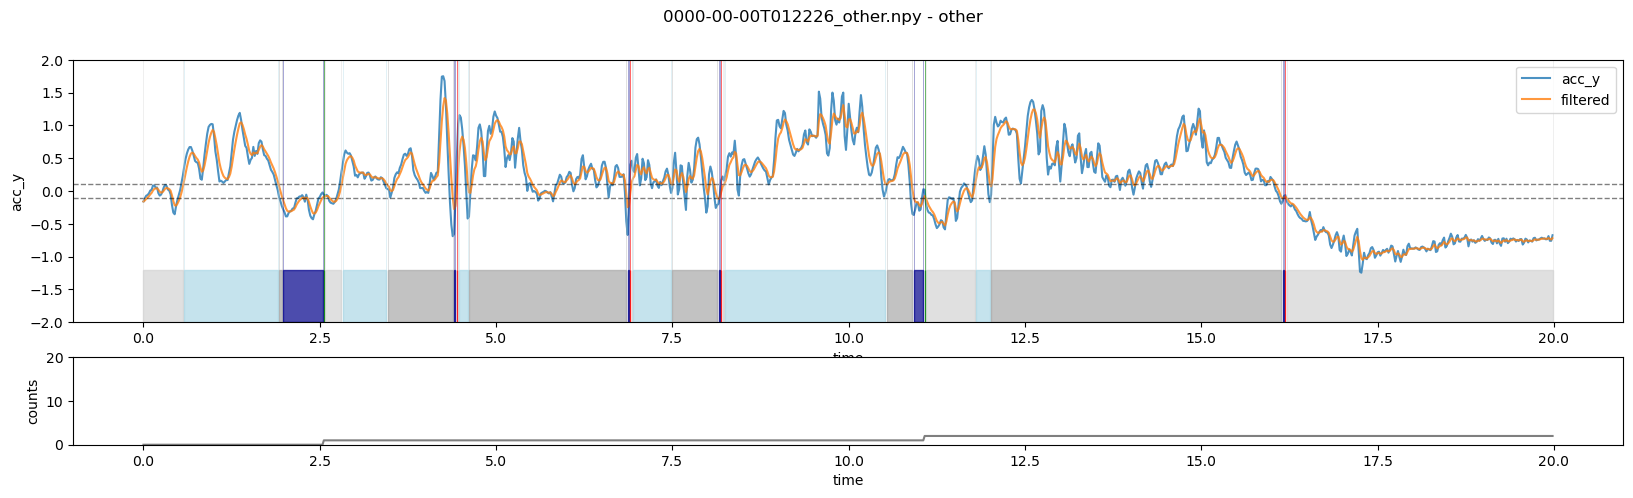

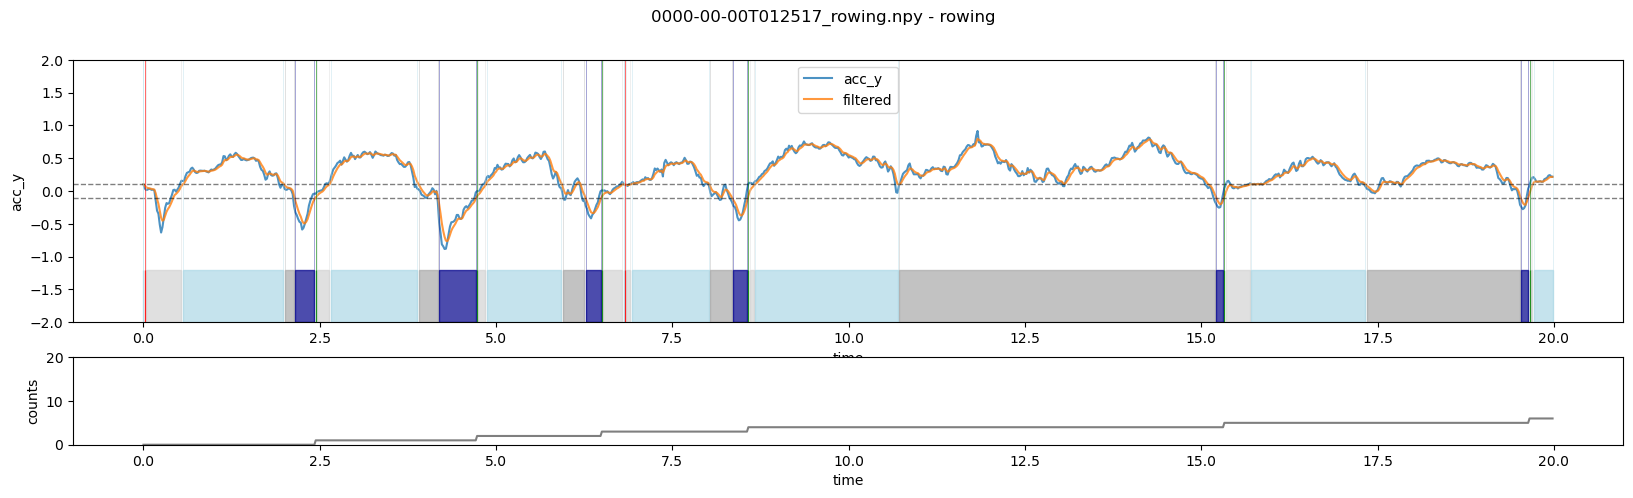

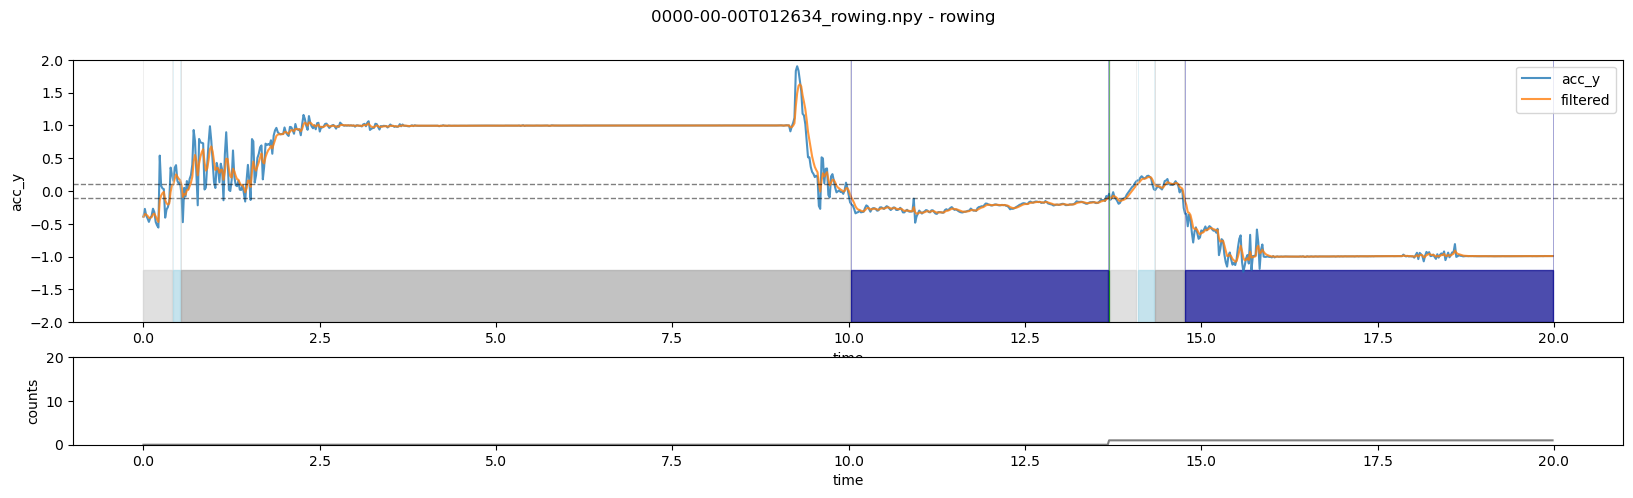

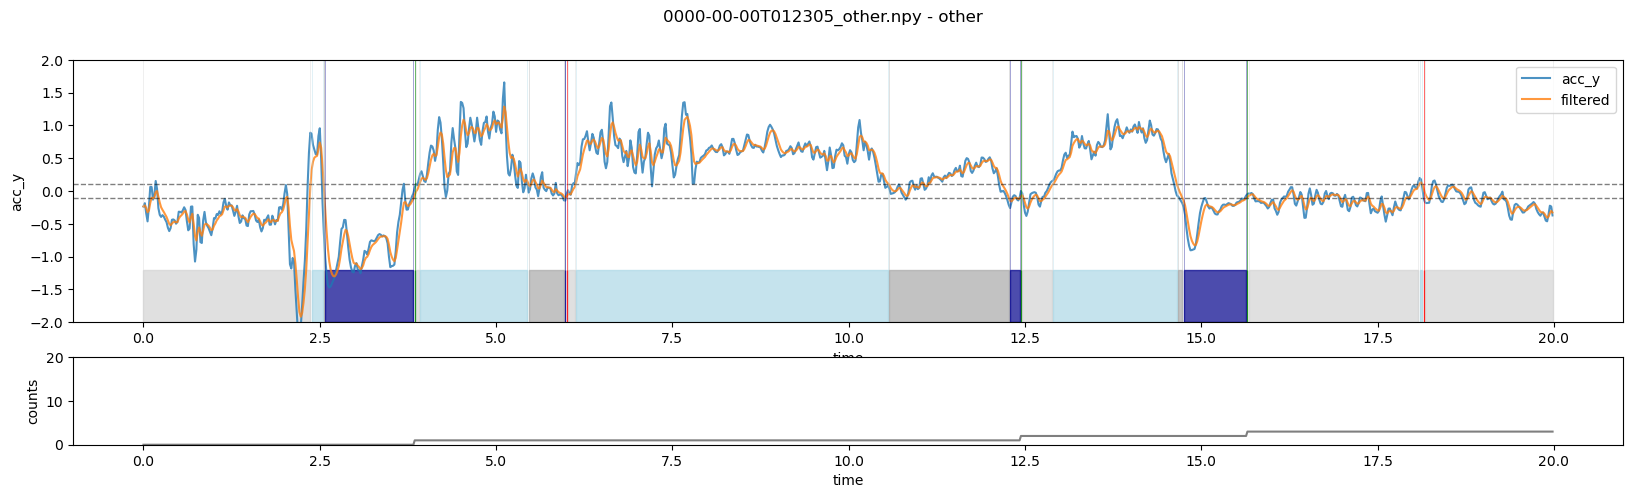

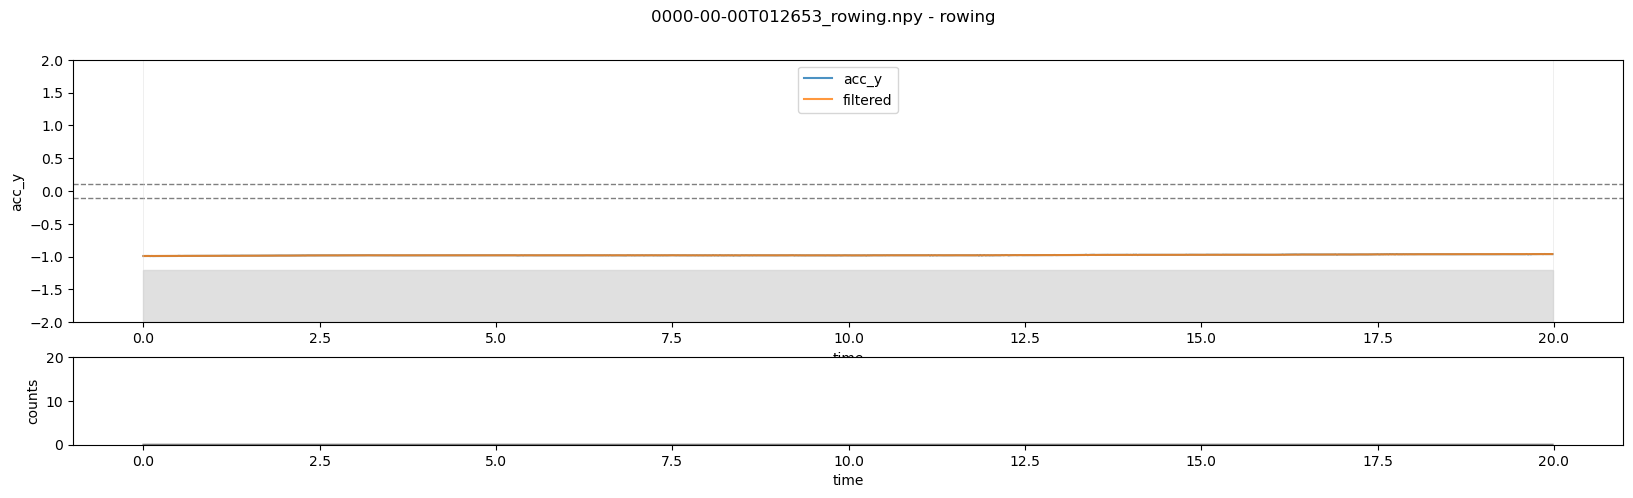

In [49]:

from matplotlib import pyplot as plt

def add_state_sections(ax, x, state, colors, ymin=0, ymax=0.2, alpha=0.3, labels=None):
    """
    Add colored background sections to a plot based on state variable.
    
    Parameters:
    - ax: matplotlib axis object
    - x: x-axis data (time or index)
    - state: integer state array (same length as x)
    - colors: list of colors, one per unique state
    - ymin: bottom of colored section (in axis coordinates, 0-1)
    - ymax: top of colored section (in axis coordinates, 0-1)
    - alpha: transparency (0-1)
    - labels: optional list of labels for legend
    """
    np = numpy
    unique_states = np.unique(state)
    
    for s in unique_states:
        mask = (state == s)
        indices = np.where(mask)[0]

        # Find contiguous sections
        splits = np.where(np.diff(indices) != 1)[0] + 1
        sections = np.split(indices, splits)
        
        label = labels[s] if labels else f'State {s}'
        
        for i, section in enumerate(sections):
            if len(section) > 0:
                # Only add label once per state
                lbl = label if i == 0 else None
                ax.axvspan(x[section[0]], x[section[-1]], 
                          ymin=ymin, ymax=ymax,
                          alpha=alpha, color=colors[s], label=lbl)
                ax.axvline(x[section[0]], ls='-', lw=0.5, alpha=0.5, color=colors[s])
                ax.axvline(x[section[-1]], ls='-', lw=0.5, alpha=0.5, color=colors[s])

def plot_recording(rec):

    title = rec.filename + ' - ' + rec.classname
    
    data = rec.data.reset_index()
    
    fig, axs = plt.subplots(2, figsize=(20, 5), gridspec_kw={'height_ratios': [3, 1]})
    ax = axs[0]
    count_ax = axs[1]
    fig.suptitle(title)
    
    p = DataProcessor(
        lowpass_cutoff=4.0,
        samplerate=52,
        pos_level=0.1,
        neg_level=-0.1,
        pos_time_min=0.05,
        neg_time_min=0.05,
    )

    import array
    values = array.array('f', rec.data['acc_y'])
    states = array.array('i', (-1 for i in range(len(values))))
    filtered = array.array('f', (0 for i in range(len(values))))
    
    p.process(values, filtered, states)

    data['filtered'] = filtered
    plot_columns = [
        #'acc_x',
        'acc_y',
        'filtered',
        #'acc_z',
        #'gyro_x',
        #'gyro_y',
        #'gyro_z',
    ]
    for col in plot_columns:
        seaborn.lineplot(ax=ax, data=data, x='time', y=col, label=col, lw=1.5, alpha=0.8)

    #seaborn.lineplot(
    
    ax.axhline(p.pos_level, ls='--', lw=1.0, alpha=0.5, color='black')
    ax.axhline(p.neg_level, ls='--', lw=1.0, alpha=0.5, color='black')

    ax.set(ylim=(-2.0, +2.0))
    #ax.set(xlim=(0.0, 10.0))

    colors = ['lightgrey', 'lightblue', 'darkgrey', 'darkblue', 'red', 'green']
    add_state_sections(ax=ax, x=data['time'], state=states, colors=colors, alpha=0.7)

    strokes = numpy.cumsum((numpy.array(states) == State.ACCEPT).astype(int))
    print(strokes)

    counts = pandas.DataFrame(dict(time=data['time'], counts=strokes))
    seaborn.lineplot(ax=count_ax, data=counts, x='time', y='counts', alpha=0.5, color='black')
    count_ax.set(ylim=(0, 20))
    #print(states)

for _, rec in files.reset_index().iterrows():
    plot_recording(rec)